In [2]:
#Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

from tensorflow.keras.layers import Layer,Dense,Conv2D,MaxPooling2D,Dropout,BatchNormalization,GlobalAveragePooling2D,ReLU,Input,multiply
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.metrics import Precision,Recall


In [ ]:
train_path = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
valid_path = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"
test_path = "/kaggle/input/new-plant-diseases-dataset/test"


In [7]:
file_train = []
label_train = []
folds = os.listdir(train_path)

for fold in folds:
    fold_path = os.path.join(train_path, fold)
    files= os.listdir(fold_path)
    for file in tqdm(files):
        img_path = os.path.join(fold_path, file)
        file_train.append(img_path)
        label_train.append(fold)

100%|██████████| 1859/1859 [00:00<00:00, 693023.83it/s]


In [8]:
file_valid = []
label_valid = []

folds = os.listdir(valid_path)

for fold in folds:
    fold_path = os.path.join(valid_path, fold)
    files = os.listdir(fold_path)
    for file in tqdm(files):
        filepath= os.path.join(fold_path,file)
        file_valid.append(filepath)
        label_valid.append(fold)

100%|██████████| 465/465 [00:00<00:00, 484438.99it/s]


In [9]:
df_train = pd.DataFrame({
    "filename" : file_train,
    "label" : label_train}
)
df_valid = pd.DataFrame({
    "filename" : file_valid,
    "label" : label_valid
})

In [10]:
def split_labels(df):
    df[['plant', 'disease']]= df['label'].str.split('___', expand=True)
    return df

df_train = split_labels(df_train)
df_valid = split_labels(df_valid)

In [46]:
df_train.head()

,Unnamed: 0,filename,label,plant,disease
0,0,./data/train\Apple___Apple_scab\00075aa8-d81a-...,Apple___Apple_scab,Apple,Apple_scab
1,1,./data/train\Apple___Apple_scab\01a66316-0e98-...,Apple___Apple_scab,Apple,Apple_scab
2,2,./data/train\Apple___Apple_scab\01a66316-0e98-...,Apple___Apple_scab,Apple,Apple_scab
3,3,./data/train\Apple___Apple_scab\01a66316-0e98-...,Apple___Apple_scab,Apple,Apple_scab
4,4,./data/train\Apple___Apple_scab\01a66316-0e98-...,Apple___Apple_scab,Apple,Apple_scab


In [10]:
df_train.to_csv("Train.csv")
df_valid.to_csv("Valid.csv")

In [3]:
df_train = pd.read_csv("Train.csv")
df_valid = pd.read_csv("Valid.csv")

In [29]:
df_valid.head()

,Unnamed: 0,filename,label,plant,disease
0,0,./data/valid\Apple___Apple_scab\00075aa8-d81a-...,Apple___Apple_scab,Apple,Apple_scab
1,1,./data/valid\Apple___Apple_scab\00075aa8-d81a-...,Apple___Apple_scab,Apple,Apple_scab
2,2,./data/valid\Apple___Apple_scab\00075aa8-d81a-...,Apple___Apple_scab,Apple,Apple_scab
3,3,./data/valid\Apple___Apple_scab\01f3deaa-6143-...,Apple___Apple_scab,Apple,Apple_scab
4,4,./data/valid\Apple___Apple_scab\0208f4eb-45a4-...,Apple___Apple_scab,Apple,Apple_scab


In [4]:
plants = sorted(df_train['plant'].unique())
diseases_per_plant = {
    plant: sorted(df_train[df_train['plant'] == plant]['disease'].unique())
    for plant in plants
}

In [47]:
plants

['Apple',
 'Blueberry',
 'Cherry_(including_sour)',
 'Corn_(maize)',
 'Grape',
 'Orange',
 'Peach',
 'Pepper,_bell',
 'Potato',
 'Raspberry',
 'Soybean',
 'Squash',
 'Strawberry',
 'Tomato']

In [13]:
diseases_per_plant

{'Apple': ['Apple_scab', 'Black_rot', 'Cedar_apple_rust', 'healthy'],
 'Blueberry': ['healthy'],
 'Cherry_(including_sour)': ['Powdery_mildew', 'healthy'],
 'Corn_(maize)': ['Cercospora_leaf_spot Gray_leaf_spot',
  'Common_rust_',
  'Northern_Leaf_Blight',
  'healthy'],
 'Grape': ['Black_rot',
  'Esca_(Black_Measles)',
  'Leaf_blight_(Isariopsis_Leaf_Spot)',
  'healthy'],
 'Orange': ['Haunglongbing_(Citrus_greening)'],
 'Peach': ['Bacterial_spot', 'healthy'],
 'Pepper,_bell': ['Bacterial_spot', 'healthy'],
 'Potato': ['Early_blight', 'Late_blight', 'healthy'],
 'Raspberry': ['healthy'],
 'Soybean': ['healthy'],
 'Squash': ['Powdery_mildew'],
 'Strawberry': ['Leaf_scorch', 'healthy'],
 'Tomato': ['Bacterial_spot',
  'Early_blight',
  'Late_blight',
  'Leaf_Mold',
  'Septoria_leaf_spot',
  'Spider_mites Two-spotted_spider_mite',
  'Target_Spot',
  'Tomato_Yellow_Leaf_Curl_Virus',
  'Tomato_mosaic_virus',
  'healthy']}

### New Architecture

In [12]:
def create_hierarchical_model(num_plants, num_diseases, input_shape):
    inputs = Input(shape=input_shape)
    
    # Initial Block
    x = Conv2D(32, (3,3), activation='relu')(inputs)
    x = Conv2D(32, (3,3), activation='relu')(x)
    x = BatchNormalization()(x) 
    x = MaxPooling2D((2,2))(x)
    
    # Intermediate Block
    x = Conv2D(64, (3,3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2,2)(x)

    x = Conv2D(128, (3,3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2,2)(x)

    # Deep Feature Extraction Block
    x = Conv2D(256, (3,3), activation='relu', padding="same")(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3,3), activation='relu', padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2,2)(x)
    
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    
    # Plant Classification 
    plant_output = Dense(num_plants, activation='softmax', name='plant_out')(x)
    
    # Single Disease Classification Output
    disease_output = Dense(num_diseases, activation='softmax', name='disease_out')(x)

    return Model(inputs, [plant_output , disease_output])


In [13]:
input_shape = (224, 224, 3)
cnn = create_hierarchical_model(
    num_plants=len(plants),
    num_diseases= max(len(d) for d in diseases_per_plant.values()),
    input_shape=input_shape
)

### Data Generator

In [16]:
class HierarchicalGenerator(ImageDataGenerator):
    def __init__(self, plants, diseases_per_plant, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.plants = plants
        self.diseases_per_plant = diseases_per_plant

    def flow_from_dataframe(self, df, **kwargs):
        gen = super().flow_from_dataframe(df, class_mode='raw', **kwargs)
        
        self.n = len(gen)

        # Define output signatures 
        output_signature = (
            tf.TensorSpec(shape=(None, 224, 224, 3)),(  
            tf.TensorSpec(shape=(None, len(self.plants))),  
            tf.TensorSpec(shape=(None, max(len(v) for v in self.diseases_per_plant.values()))  
            ))
        )
        
        return tf.data.Dataset.from_generator(
            lambda: self._gen_wrapper(gen),
            output_signature=output_signature
        )

    def __len__(self):
        return self.n
    def _gen_wrapper(self, gen):
        for X, y in gen:
            plant_labels = []
            disease_labels = []
            for label in y:
                plant_name, disease_name = label.split('___')
                plant_idx = self.plants.index(plant_name)
                disease_idx = self.diseases_per_plant[plant_name].index(disease_name)
                
                plant_labels.append(plant_idx)
                disease_labels.append(disease_idx)
            
            
            plant_onehot = tf.keras.utils.to_categorical(plant_labels, num_classes=len(self.plants))
            disease_onehot = tf.keras.utils.to_categorical(disease_labels, num_classes=max(len(v) for v in self.diseases_per_plant.values()))
            
            yield X, (plant_onehot, disease_onehot)

In [17]:

train_gen = HierarchicalGenerator(plants,diseases_per_plant,rescale=1./255,zoom_range= 0.2,horizontal_flip=True).flow_from_dataframe(
    df_train,
    x_col='filename',
    y_col='label',
    target_size=(224,224),
    batch_size=32,
    shuffle = True
)
valid_gen = HierarchicalGenerator(plants,diseases_per_plant,rescale=1./255).flow_from_dataframe(
    df_valid,
    x_col = "filename",
    y_col = "label",
    target_size=(224,224)
)

Found 70295 validated image filenames.
Found 17572 validated image filenames.


In [18]:
len(valid_gen)

TypeError: The dataset length is unknown.

In [26]:
from tensorflow.keras.optimizers import AdamW

optimizer = AdamW(
    learning_rate=3e-5,      
    weight_decay=1e-4,       
    global_clipnorm=1.0,     
    beta_1=0.9,              
    beta_2=0.999             
)

In [27]:
cnn.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 222, 222, 32)   │            896 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 220, 220, 32)   │          9,248 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 220, 220, 32)   │            128 │ conv2d_7[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 110, 110, 32)   │              0 │ batch_normalization_5… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 108, 108, 64)   │         18,496 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 108, 108, 64)   │            256 │ conv2d_8[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 54, 54, 64)     │              0 │ batch_normalization_6… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 52, 52, 128)    │         73,856 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 52, 52, 128)    │            512 │ conv2d_9[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 26, 26, 128)    │              0 │ batch_normalization_7… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 26, 26, 256)    │        295,168 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 26, 26, 256)    │          1,024 │ conv2d_10[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 26, 26, 256)    │        590,080 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 26, 26, 256)    │          1,024 │ conv2d_11[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 996,856 (3.80 MB)

 Trainable params: 995,384 (3.80 MB)

 Non-trainable params: 1,472 (5.75 KB)

### Model Training

In [28]:
batch_size = 32 
steps_per_epoch = len(df_train) // batch_size
validation_steps = len(df_valid) // batch_size


if len(df_train) % batch_size != 0:
    steps_per_epoch += 1
if len(df_valid) % batch_size != 0:
    validation_steps += 1

In [29]:
cnn.compile(
    optimizer=optimizer,
    loss={'plant_out': 'categorical_crossentropy', 'disease_out': 'categorical_crossentropy'},
    loss_weights=[1.0, 0.1],
    metrics={
        'plant_out': ['accuracy', Precision(name="plant_precision"), Recall(name="plant_recall")],
        'disease_out': ['accuracy', Precision(name="disease_precision"), Recall(name="disease_recall")]
    }
)

In [30]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3
)


In [2]:
history = cnn.fit(
    train_gen,
    steps_per_epoch = steps_per_epoch,
    epochs = 2,
    callbacks = [early_stop,reduce_lr],
    validation_data = valid_gen,
    validation_steps= validation_steps
)

NameError: name 'cnn' is not defined

In [32]:
cnn.save("Plant_disease_detection_V2.h5")

In [14]:
from tensorflow.keras.models import load_model
model = load_model("./models/Plant_disease_detection_V2.h5")

In [22]:
# Replace len(valid_gen) with this:
validation_steps = len(df_valid) // 32
if len(df_valid) % 32 != 0:
    validation_steps += 1

In [37]:
df_valid

,Unnamed: 0,filename,label,plant,disease
0,0,./data/valid\Apple___Apple_scab\00075aa8-d81a-...,Apple___Apple_scab,Apple,Apple_scab
1,1,./data/valid\Apple___Apple_scab\00075aa8-d81a-...,Apple___Apple_scab,Apple,Apple_scab
2,2,./data/valid\Apple___Apple_scab\00075aa8-d81a-...,Apple___Apple_scab,Apple,Apple_scab
3,3,./data/valid\Apple___Apple_scab\01f3deaa-6143-...,Apple___Apple_scab,Apple,Apple_scab
4,4,./data/valid\Apple___Apple_scab\0208f4eb-45a4-...,Apple___Apple_scab,Apple,Apple_scab
...,...,...,...,...,...
17567,17567,./data/valid\Tomato___Tomato_Yellow_Leaf_Curl_...,Tomato___Tomato_Yellow_Leaf_Curl_Virus,Tomato,Tomato_Yellow_Leaf_Curl_Virus
17568,17568,./data/valid\Tomato___Tomato_Yellow_Leaf_Curl_...,Tomato___Tomato_Yellow_Leaf_Curl_Virus,Tomato,Tomato_Yellow_Leaf_Curl_Virus
17569,17569,./data/valid\Tomato___Tomato_Yellow_Leaf_Curl_...,Tomato___Tomato_Yellow_Leaf_Curl_Virus,Tomato,Tomato_Yellow_Leaf_Curl_Virus
17570,17570,./data/valid\Tomato___Tomato_Yellow_Leaf_Curl_...,Tomato___Tomato_Yellow_Leaf_Curl_Virus,Tomato,Tomato_Yellow_Leaf_Curl_Virus


In [40]:
pred_plants, pred_diseases = model.predict(valid_gen,steps=validation_steps)


550/550 ━━━━━━━━━━━━━━━━━━━━ 119s 215ms/step


In [28]:
valid_gen

<_FlatMapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(None, 14), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)))>

In [26]:
plant_classes = sorted(df_train['plant'].unique())
disease_classes = []
for plant in plants:
    disease_classes.extend(diseases_per_plant[plant])
disease_classes = sorted(list(set(disease_classes)))

In [62]:
disease_classes

['Apple_scab',
 'Bacterial_spot',
 'Black_rot',
 'Cedar_apple_rust',
 'Cercospora_leaf_spot Gray_leaf_spot',
 'Common_rust_',
 'Early_blight',
 'Esca_(Black_Measles)',
 'Haunglongbing_(Citrus_greening)',
 'Late_blight',
 'Leaf_Mold',
 'Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Leaf_scorch',
 'Northern_Leaf_Blight',
 'Powdery_mildew',
 'Septoria_leaf_spot',
 'Spider_mites Two-spotted_spider_mite',
 'Target_Spot',
 'Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato_mosaic_virus',
 'healthy']

In [ ]:
cm = confusion_matrix()

In [57]:
true_plants, true_diseases = [], []
pred_plants, pred_diseases = [],[]

for i, (X, (y_plant_true, y_disease_true)) in enumerate(valid_gen.take(validation_steps)):  
    y_plant_pred, y_disease_pred = model.predict(X, verbose=0)

    # Convert tensors to numpy arrays
    y_plant_true = y_plant_true.numpy()
    y_disease_true = y_disease_true.numpy()

    # Convert one-hot encoded labels to class indices
    true_plants.extend(np.argmax(y_plant_true, axis=1))  
    true_diseases.extend(np.argmax(y_disease_true, axis=1))

    # Convert predicted probabilities to class indices
    pred_plants.extend(np.argmax(y_plant_pred, axis=1))
    pred_diseases.extend(np.argmax(y_disease_pred, axis=1))

    if i >= validation_steps - 1:  
        break


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(title)
    plt.show()

def print_classification_report(y_true, y_pred, labels):
    report = classification_report(y_true, y_pred, target_names=labels)
    print(report)



In [ ]:
plant_labels = sorted(df_train['plant'].unique())  
disease_labels = sorted(df_train['disease'].unique())  


21

In [58]:
print(f"Length of true_plants: {len(true_plants)}")
print(f"Length of pred_plants: {len(pred_plants)}")
print(f"Length of true_diseases: {len(true_diseases)}")
print(f"Length of pred_diseases: {len(pred_diseases)}")


Length of true_plants: 17572
Length of pred_plants: 17572
Length of true_diseases: 17572
Length of pred_diseases: 17572


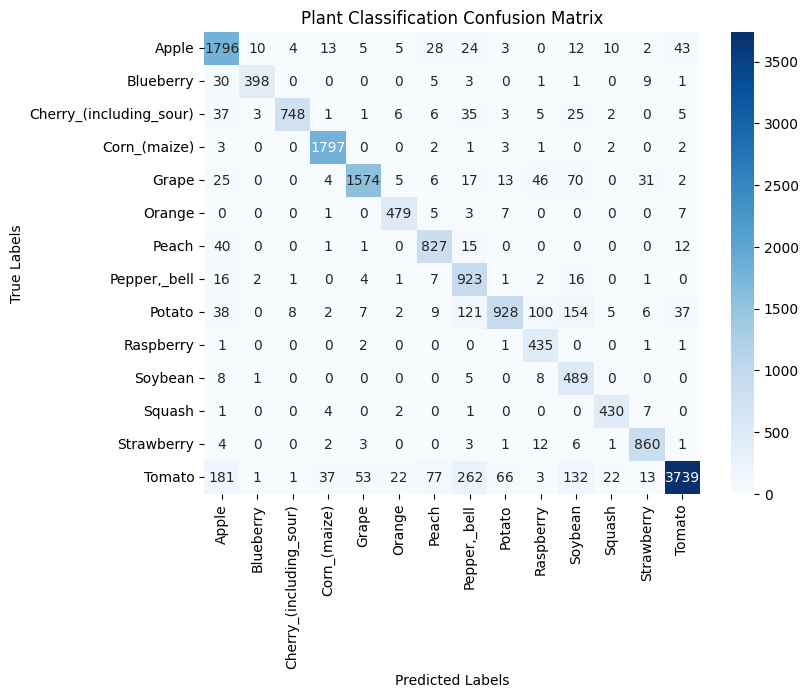

                         precision    recall  f1-score   support

                  Apple       0.82      0.92      0.87      1955
              Blueberry       0.96      0.89      0.92       448
Cherry_(including_sour)       0.98      0.85      0.91       877
           Corn_(maize)       0.97      0.99      0.98      1811
                  Grape       0.95      0.88      0.91      1793
                 Orange       0.92      0.95      0.94       502
                  Peach       0.85      0.92      0.89       896
           Pepper,_bell       0.65      0.95      0.77       974
                 Potato       0.90      0.65      0.76      1417
              Raspberry       0.71      0.99      0.83       441
                Soybean       0.54      0.96      0.69       511
                 Squash       0.91      0.97      0.94       445
             Strawberry       0.92      0.96      0.94       893
                 Tomato       0.97      0.81      0.88      4609

               accuracy

In [60]:
plot_confusion_matrix(true_plants, pred_plants, plant_labels, "Plant Classification Confusion Matrix")
print_classification_report(true_plants, pred_plants, plant_labels)

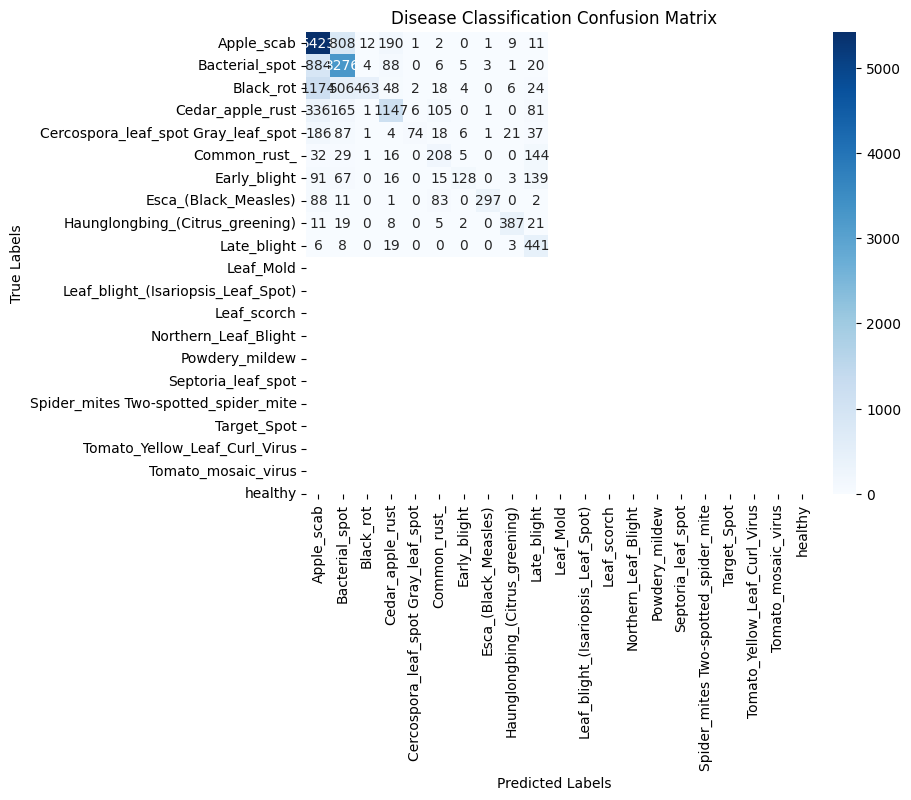

ValueError: Number of classes, 10, does not match size of target_names, 14. Try specifying the labels parameter

: 

In [ ]:
plot_confusion_matrix(true_diseases, pred_diseases, disease_labels, "Disease Classification Confusion Matrix")
print_classification_report(true_diseases, pred_diseases, diseases_per_plant)

In [63]:
print("Unique true disease labels:", np.unique(true_diseases))
print("Unique predicted disease labels:", np.unique(pred_diseases))
print("Total unique disease labels in dataset:", len(disease_labels))


Unique true disease labels: [0 1 2 3 4 5 6 7 8 9]
Unique predicted disease labels: [0 1 2 3 4 5 6 7 8 9]
Total unique disease labels in dataset: 21
